In [12]:
import pandas as pd
import nltk
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv('labeledTrainData.tsv', sep='\t')
df.head(10)

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
5,8196_8,1,I dont know why people think this is such a ba...
6,7166_2,0,"This movie could have been very good, but come..."
7,10633_1,0,I watched this video at a friend's house. I'm ...
8,319_1,0,"A friend of mine bought this film for £1, and ..."
9,8713_10,1,<br /><br />This movie is full of references. ...


In [15]:
%%time
def preprocessing(df):
    df['review'] = df.review.str.lower()
    df["document_sentences"] = df.review.str.split('.')
    df['tokenized_sentences'] = list(map(lambda x: list(map(nltk.word_tokenize, x)), df.document_sentences))
    df['tokenized_sentences'] = list(map(lambda x: list(filter(lambda lst: lst, x)), df.tokenized_sentences))
preprocessing(df)

CPU times: total: 22 s
Wall time: 22.3 s


In [16]:
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(df.drop(columns='sentiment'), df['sentiment'], test_size=0.2)

In [17]:
voc = []
for sen in train.tokenized_sentences:
    voc.extend(sen)
print(f"len voc -> {len(voc)}")
print(f"len train -> {len(train)}")


len voc -> 250005
len train -> 20000


In [18]:
import gensim

from gensim.models import Word2Vec, word2vec
num_features = 300
min_word_count = 3
num_workers = 4
context = 8
downsampling = 1e-3

Word2Vec_model = Word2Vec(
    sentences=voc,
    sg=1,
    hs=0,
    workers=num_workers,
    min_count=min_word_count,
    window=context,
    sample=downsampling,
    negative=5,
    vector_size=num_features,
    epochs=6,
)

In [19]:
def sentence_vectors(model, sentences):
    words = np.concatenate(sentences)
    model_vocab = set(model.wv.key_to_index.keys())
    sentence_vector = np.zeros(model.vector_size, dtype=np.float32)
    n_words = 0
    for word in words:
        if word in model_vocab:
            sentence_vector += model.wv[word]
            n_words += 1
    if n_words > 0:
        sentence_vector /= n_words
    return sentence_vector
train['sentence_vector'] = list(map(lambda sen_group: sentence_vectors(Word2Vec_model, sen_group), train.tokenized_sentences))

In [21]:
def vectors_to_feats(df, ndim):
    index = []
    for i in range(ndim):
        df[f'w2v_{i}'] = df['sentence_vector'].apply(lambda x: x[i])
        index.append(f'w2v_{i}')
    return df[index]
X_train = vectors_to_feats(train, num_features)
X_train.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_290,w2v_291,w2v_292,w2v_293,w2v_294,w2v_295,w2v_296,w2v_297,w2v_298,w2v_299
18280,-0.009772,0.164128,0.023131,0.054187,0.025763,-0.056875,0.056502,0.150644,-0.032882,-0.107313,...,0.008985,0.258906,0.122238,0.098770,0.159722,0.128090,0.042175,-0.113228,0.023970,0.029955
24687,-0.008587,0.155873,0.005274,0.038484,0.029841,-0.056161,0.055510,0.164101,-0.002772,-0.087553,...,0.046305,0.247495,0.153971,0.115216,0.201774,0.135318,0.031946,-0.107392,-0.005483,0.044077
9797,-0.022158,0.154751,0.007040,0.035704,0.030567,-0.023643,0.052222,0.094238,-0.003410,-0.071918,...,0.056777,0.270079,0.147153,0.079982,0.246260,0.129809,-0.004249,-0.145400,0.047435,0.053943
23914,-0.007736,0.145606,0.036622,0.043677,0.055197,-0.097618,0.065769,0.173223,0.013291,-0.084588,...,0.015523,0.209780,0.094527,0.089810,0.202417,0.104152,0.007325,-0.089612,0.078279,0.019988
19132,-0.002049,0.131118,0.017976,0.073203,0.032259,-0.049786,0.073559,0.188497,-0.015832,-0.073749,...,-0.005284,0.267250,0.107446,0.134093,0.188896,0.128443,-0.002217,-0.091089,-0.005415,0.048713


In [23]:
test['sentence_vector'] = list(map(lambda sen_group: sentence_vectors(Word2Vec_model, sen_group), test.tokenized_sentences))
X_test = vectors_to_feats(test, num_features)

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [25]:
from sklearn.metrics import roc_auc_score, confusion_matrix
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

0.936441825767303

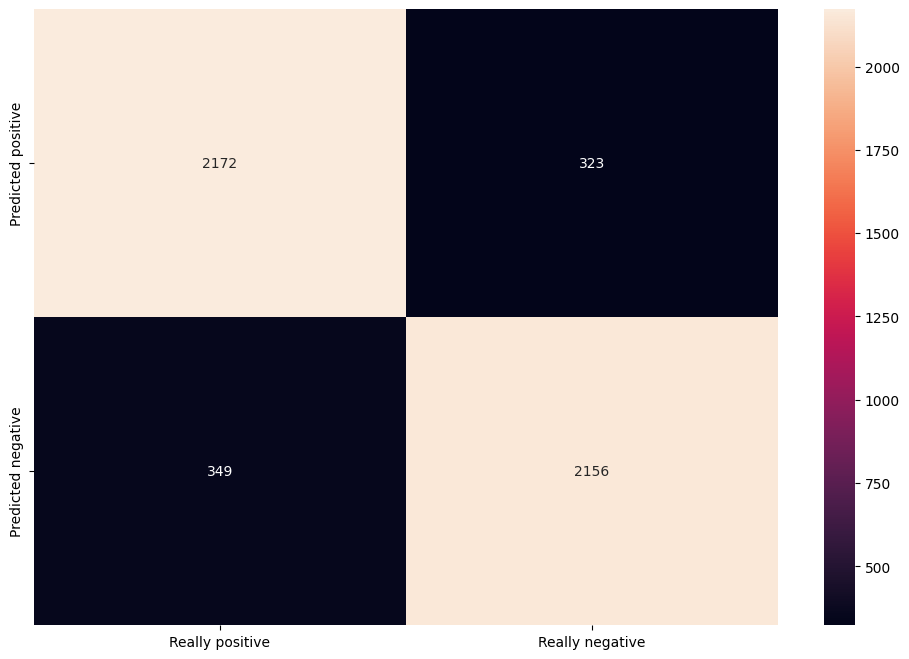

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(y_test, lr.predict(X_test)),
                     index=["Predicted positive", "Predicted negative"],
                     columns=["Really positive", "Really negative"])
plt.figure(figsize = (12, 8))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()